In [15]:
import pandas as pd
import numpy as np
import pickle
pd.set_option('display.max_columns', 350)
from collections import Counter
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns
import shap
 
import sklearn
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder, OneHotEncoder 
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from statistics import mean, stdev
from sklearn.feature_selection import RFE, SelectFromModel, SelectKBest, chi2, RFE
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.model_selection import TimeSeriesSplit
 
import imblearn
import xgboost as xgb 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier 
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler  
  
from sklearn.compose import ColumnTransformer  
from imxgboost.imbalance_xgb import imbalance_xgboost as imb_xgb 
import functools 
from sklearn.model_selection import LeaveOneOut, cross_validate, KFold, GridSearchCV, RandomizedSearchCV,cross_val_score, RepeatedStratifiedKFold, StratifiedKFold
  
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import f1_score, classification_report, roc_auc_score, make_scorer, precision_score, recall_score, roc_auc_score
from sklearn.metrics import fbeta_score, make_scorer, recall_score, log_loss, confusion_matrix, precision_recall_curve, auc,accuracy_score, precision_score,  roc_curve
from sklearn.metrics import average_precision_score,precision_recall_curve, auc,  accuracy_score    
from sklearn.model_selection import train_test_split       
from sklearn.metrics import make_scorer 
from tabulate import tabulate
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, auc
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, PowerTransformer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from prettytable import PrettyTable
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.metrics import roc_auc_score, average_precision_score, classification_report
from imblearn.pipeline import Pipeline as ImbalancedPipeline
from sklearn.feature_selection import SelectFromModel
import shap
from sklearn.utils import shuffle

In [2]:
q = pd.read_pickle("FinTech3_1960.pkl")
 

In [3]:
# Sorting by timestamp
qual = q.sort_values(by='months_since_1960_MEAS_ACCH_DATE_OPENED')

In [4]:
# Separate the features and target variable
X = qual.drop(['Target'], axis=1)  
y = qual['Target']

In [5]:
print(X.columns)

Index(['IDacc', 'SNAPNUMacc', 'MEAS_ACCH_ORIGINATOR',
       'MEAS_ACCL_STRAY_PAYMENT_AMT', 'MEAS_ACCL_APLL_IS_NEW',
       'MEAS_ACCL_APLL_FORBORNE', 'MEAS_ACCL_APPL_TYPE',
       'MEAS_ACCL_PAID_IN_FULL_CM', 'MEAS_ACCL_APPLICATION_SUCCESSFUL',
       'MEAS_ACCL_UNDERWRITING_SEGMENT',
       ...
       'months_since_1960_MEAS_ACCL_PHONE_RPC_DATE_FIRST',
       'months_since_1960_MEAS_ACCL_PHONE_RPC_DATE_LATEST',
       'months_since_1960_MEAS_CUSL_MIN_COMMUNICATION_DATE_3M',
       'months_since_1960_MEAS_CUSL_ADMINISTRATION_STATUS_DATE',
       'months_since_1960_MEAS_CUSL_PRIORITY_CUSTOMER_STATUS_DATE',
       'months_since_1960_MEAS_CUSL_LAST_PAYMENT_DATE',
       'months_since_1960_MEAS_CUSL_LAST_DEFAULT_DATE',
       'months_since_1960_MEAS_CUSL_FIRST_DEFAULT_DATE',
       'months_since_1960_MEAS_CUSH_BIRTHDATE',
       'months_since_1960_MEAS_CUSH_DATE_NOMINAL'],
      dtype='object', length=249)


In [6]:
duplicate_columns = X.columns[X.columns.duplicated()]
print("Duplicate Columns:", duplicate_columns)


Duplicate Columns: Index([], dtype='object')


In [7]:
print("DataFrame Info:")
print(X.info())


DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
Index: 414497 entries, 1114860 to 922055
Columns: 249 entries, IDacc to months_since_1960_MEAS_CUSH_DATE_NOMINAL
dtypes: float64(107), int32(23), int64(41), object(78)
memory usage: 754.2+ MB
None


In [8]:
# calculate percentage of each class of target variable
class_ratio = y.value_counts(normalize=True) * 100
class_ratio

Target
0    99.80796
1     0.19204
Name: proportion, dtype: float64

In [9]:
#Count classes 
"Class distribution:", Counter(y)

('Class distribution:', Counter({0: 413701, 1: 796}))

In [10]:
# Encoding 
categorical_columns = X.select_dtypes(include=['object']).columns
numerical_columns = X.select_dtypes(include=['float64', 'int64']).columns

# One-hot encode categorical features using get_dummies
X_encoded = pd.get_dummies(X[categorical_columns], drop_first=True, prefix_sep='_')

# Concatenate numerical and one-hot encoded categorical columns
X_combined = pd.concat([X[numerical_columns], X_encoded], axis=1)

# Sort the combined dataframe by index
X_combined.sort_index(inplace=True)

In [11]:
# Splitting the data into train, test, and validation sets
X_train, X_temp, y_train, y_temp = train_test_split(X_combined, y, test_size=0.2, random_state=42, stratify=y)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)


In [16]:
from sklearn.utils import shuffle

# Reset the index of both X_train and y_train to ensure they align
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

# Separate the positive and negative classes from the training set
positive_class = X_train[y_train == 1]
negative_class = X_train[y_train == 0]

# Get all positive class labels and negative class labels
positive_class_labels = y_train[y_train == 1]
negative_class_labels = y_train[y_train == 0]

# Check how many negative class instances are available
negative_class_count = len(negative_class)

# Determine how many negative samples to take (min of available or 400,000)
n_negative_samples = min(400000, negative_class_count)

# Sample the required number of negative class instances
negative_class_sampled = negative_class.sample(n=n_negative_samples, random_state=42)
negative_class_labels_sampled = negative_class_labels.loc[negative_class_sampled.index]

# Concatenate the positive class with the sampled negative class
X_train_new = pd.concat([positive_class, negative_class_sampled], axis=0)
y_train_new = pd.concat([positive_class_labels, negative_class_labels_sampled], axis=0)

# Shuffle the new training set to avoid any ordering bias
X_train_new, y_train_new = shuffle(X_train_new, y_train_new, random_state=42)



In [17]:
# SelectFromModel for feature selection
selector = SelectFromModel(RandomForestClassifier(n_estimators=100), threshold='mean')
selector.fit(X_train_new, y_train_new)

# Get the selected feature indices
selected_feature_indices = selector.get_support(indices=True)

# Sransform datasets using the selected features
X_train_selected = selector.transform(X_train_new)
X_test_selected = selector.transform(X_test)
X_val_selected = selector.transform(X_val)


# Get the indices of the selected features
selected_feature_indices = selector.get_support(indices=True)
selected_feature_names = X_combined.columns[selected_feature_indices]


In [18]:
# Resampling strategies
resampling_strategy = {
    'minority': 0.05,  # Oversample the minority class to 5% of the dataset
    'majority': 0.8    # Undersample the majority class to 80% of the dataset
}

# Pipeline with SMOTE and RandomUnderSampler
pipeline = ImbalancedPipeline([
    ('oversample', SMOTE(sampling_strategy=resampling_strategy['minority'], n_jobs=-1)),
    ('undersample', RandomUnderSampler(sampling_strategy=resampling_strategy['majority'])),
    #('scaler', RobustScaler())
])

# Fit and resample the training data
X_train_resampled, y_train_resampled = pipeline.fit_resample(X_train_selected, y_train_new)

# Check the class distribution after resampling
class_distribution_after = pd.Series(y_train_resampled).value_counts(normalize=True)
print("Class distribution after resampling:", class_distribution_after)



  File "C:\Users\Katerina\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\Katerina\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Katerina\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\Katerina\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


Class distribution after resampling: Target
0    0.555556
1    0.444444
Name: proportion, dtype: float64


In [19]:
# Apply RobustScaler after selecting the best features
#This ensures your feature space is reduced to the most important features, the class imbalance is handled correctly, 
#and everything is scaled consistently.
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test_selected)
X_val_scaled = scaler.transform(X_val_selected)
y_train = y_train_resampled

In [20]:
# Create a table for results
table = PrettyTable()
table.field_names = ["Model", "ROC-AUC", "Precision-Recall AUC"]

Random Forest

In [21]:
# fit Random Forest
rf = RandomForestClassifier(random_state=42)  #class_weight='balanced')
rf.fit(X_train_scaled, y_train)

# Predict probabilities on the test set
y_pred_proba = rf.predict_proba(X_test_scaled)[:, 1]


# Evaluate ROC-AUC
roc_auc_rf = roc_auc_score(y_test, y_pred_proba)
print(f'ROC-AUC: {roc_auc_rf:.4f}')

#Precision-Recall AUC
pr_auc_rf = average_precision_score(y_test, y_pred_proba)
print(f'Precision-Recall AUC: {pr_auc_rf:.4f}')
table.add_row(["RandomForest", f"{roc_auc_rf:.4f}", f"{pr_auc_rf:.4f}"])

# Classification Report
y_pred = rf.predict(X_test_scaled)
class_report = classification_report(y_test, y_pred)
print(class_report)

ROC-AUC: 0.4825
Precision-Recall AUC: 0.0019
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     41370
           1       0.00      0.00      0.00        80

    accuracy                           1.00     41450
   macro avg       0.50      0.50      0.50     41450
weighted avg       1.00      1.00      1.00     41450



Logistic Regression

In [22]:
# Fit Logistic Regression
lr = LogisticRegression(random_state=42) # class_weight='balanced')
lr.fit(X_train_scaled, y_train)

# Predict probabilities on the test set
y_pred_proba_lr = lr.predict_proba(X_test_scaled)[:, 1]

# Evaluate ROC-AUC
roc_auc_lr = roc_auc_score(y_test, y_pred_proba_lr)
print(f'ROC-AUC (Logistic Regression): {roc_auc_lr:.4f}')

# Precision-Recall AUC
pr_auc_lr = average_precision_score(y_test, y_pred_proba)
print(f'Precision-Recall AUC (Logistic Regression): {pr_auc_lr:.4f}')

table.add_row(["LogisticRegression", f"{roc_auc_lr:.4f}", f"{pr_auc_lr:.4f}"])

# Classification Report
y_pred_lr = lr.predict(X_test_scaled)
class_report_lr = classification_report(y_test, y_pred_lr)
print(class_report_lr)


ROC-AUC (Logistic Regression): 0.4590
Precision-Recall AUC (Logistic Regression): 0.0019
              precision    recall  f1-score   support

           0       1.00      0.81      0.90     41370
           1       0.00      0.14      0.00        80

    accuracy                           0.81     41450
   macro avg       0.50      0.47      0.45     41450
weighted avg       1.00      0.81      0.89     41450



XGBoost

In [23]:
# XGBoost
xgb = XGBClassifier(random_state=42)# scale_pos_weight=9)
xgb.fit(X_train_scaled, y_train)

# Predict probabilities on the test set
y_pred_proba = xgb.predict_proba(X_test_scaled)[:, 1]

# Evaluate ROC-AUC
roc_auc_xgb = roc_auc_score(y_test, y_pred_proba)
print(f'ROC-AUC: {roc_auc_xgb:.4f}') 

#Precision-Recall AUC
pr_auc_xgb = average_precision_score(y_test, y_pred_proba)
print(f'Precision-Recall AUC: {pr_auc_xgb:.4f}')
table.add_row(["XGBoost", f"{roc_auc_xgb:.4f}", f"{pr_auc_xgb:.4f}"])

# Classification Report
y_pred = xgb.predict(X_test_scaled)
class_report = classification_report(y_test, y_pred) 
print(class_report)

ROC-AUC: 0.4711
Precision-Recall AUC: 0.0019
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     41370
           1       0.00      0.00      0.00        80

    accuracy                           1.00     41450
   macro avg       0.50      0.50      0.50     41450
weighted avg       1.00      1.00      1.00     41450



In [24]:
print (table)

+--------------------+---------+----------------------+
|       Model        | ROC-AUC | Precision-Recall AUC |
+--------------------+---------+----------------------+
|    RandomForest    |  0.4825 |        0.0019        |
| LogisticRegression |  0.4590 |        0.0019        |
|      XGBoost       |  0.4711 |        0.0019        |
+--------------------+---------+----------------------+


ROC-AUC: 0.4711
Precision-Recall AUC: 0.0019
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     41370
           1       0.00      0.00      0.00        80

    accuracy                           1.00     41450
   macro avg       0.50      0.50      0.50     41450
weighted avg       1.00      1.00      1.00     41450



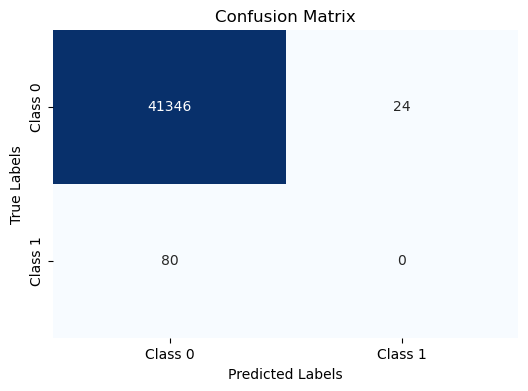

In [25]:
# Evaluate on the test set
y_pred_proba = xgb.predict_proba(X_test_scaled)[:, 1]

# Calculate ROC-AUC and Precision-Recall AUC
roc_auc_xgb = roc_auc_score(y_test, y_pred_proba)
pr_auc_xgb = average_precision_score(y_test, y_pred_proba)

# Print the evaluation metrics
print(f'ROC-AUC: {roc_auc_xgb:.4f}')
print(f'Precision-Recall AUC: {pr_auc_xgb:.4f}')

# Classification report
y_pred = xgb.predict(X_test_scaled)
class_report = classification_report(y_test, y_pred)
print(class_report)

# Confusion Matrix plot
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

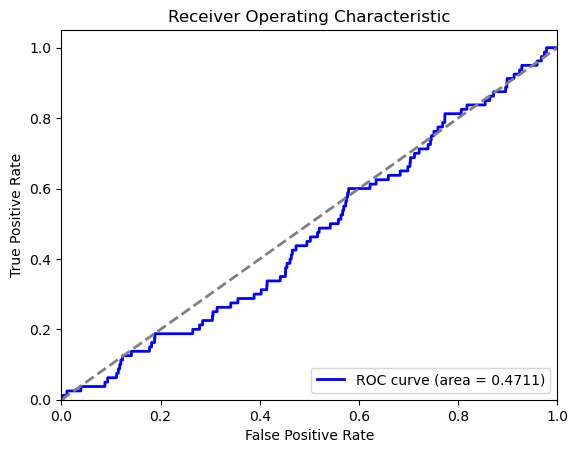

In [26]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc_xgb:.4f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

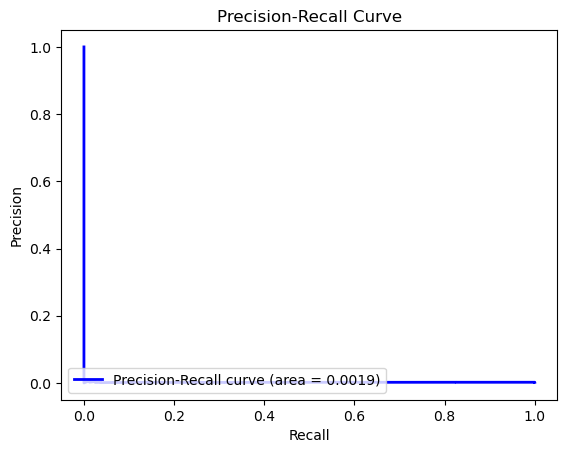

In [27]:
# Calculate precision and recall
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)

# Precision-Recall Curve
plt.figure()
plt.plot(recall, precision, color='blue', lw=2, label=f'Precision-Recall curve (area = {pr_auc_xgb:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")

# Get the indices of the selected features
selected_feature_indices = selector.get_support(indices=True)
selected_feature_names = X_train.columns[selected_feature_indices]
plt.show()

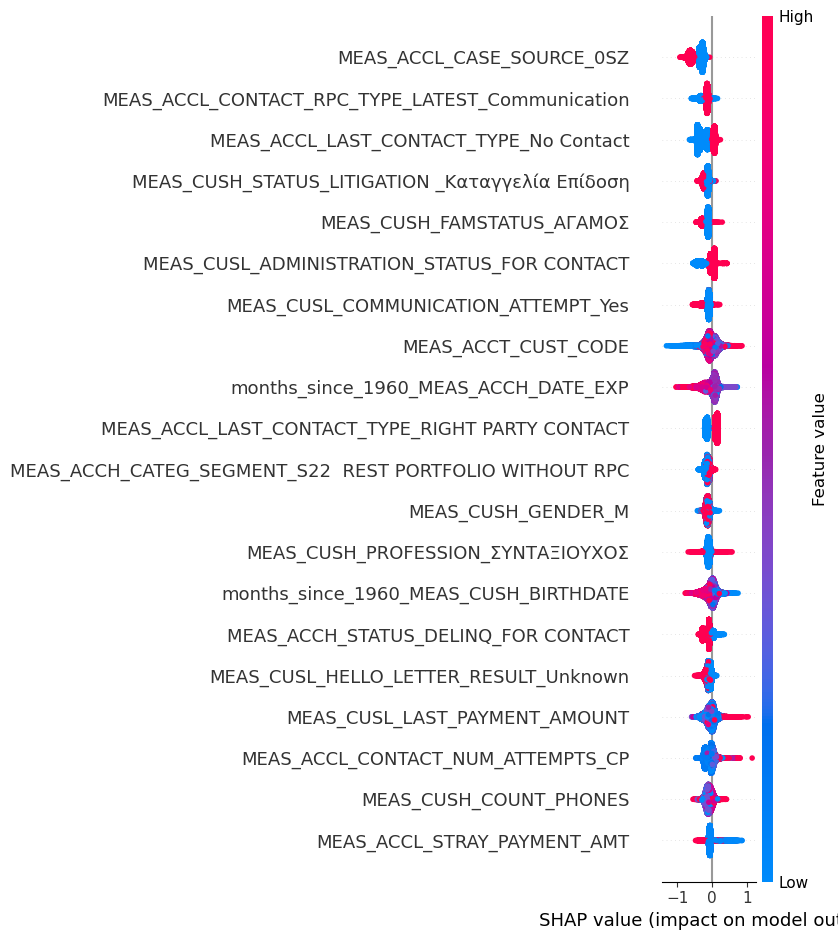

In [28]:
# Get the indices of the selected features
selected_feature_indices = selector.get_support(indices=True)
selected_feature_names = X_train.columns[selected_feature_indices]

xgb.fit(X_train_scaled, y_train)
# Create the SHAP explainer for the trained XGBoost model using TreeExplainer
explainer = shap.TreeExplainer(xgb)

# Compute SHAP values for the test set with the selected features
shap_values = explainer.shap_values(X_test_scaled)

# Plot the SHAP summary plot using the selected features
shap.summary_plot(shap_values, X_test_scaled, feature_names=selected_feature_names)